In [1]:
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import pandas as panda
import numpy as np
class DatasetHindawi(Dataset):    
    def __init__(self, file_path, transform=None):
        self.csv_train = panda.read_csv(file_path)
        self.transform = transform
        self.raw_train = self.csv_train.to_numpy()
        #self.filtered_train_indexes = np.where(( (raw_train == 'character_01_ka') | (raw_train == 'character_02_kha') | (raw_train == 'character_03_ga') | (raw_train == 'character_04_gha') | (raw_train == 'character_05_kna') ))
        #filtered_train = raw_train[filtered_train_indexes[0],:]
        self.filtered_train = self.raw_train
        self.y_train = self.filtered_train[:,1024]
        self.lookupTable_y, self.y_train_indexed = np.unique(self.y_train, return_inverse=True)
        print(self.y_train_indexed)
        self.x_train = self.filtered_train[:,:-1]
        self.x_train = self.x_train.astype(dtype=float)
        
    def __len__(self):
        return len(self.raw_train)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, we use ToTensor(), so we define the numpy array like (H, W, C)
        image = self.x_train[index].reshape(1,32,32)
        label = self.y_train_indexed[index]        
        if self.transform is not None:
            image = self.transform(image)            
        return image, label

In [2]:
train_dataset = DatasetHindawi('/kaggle/input/devanagari-character-set/data.csv')
#img, lab = train_dataset2.__getitem__(0)
#print(img.shape)
#print(lab)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
train_iter = iter(train_loader)
images, labels = train_iter.next()
print(type(labels))

[ 0  0  0 ... 45 45 45]
<class 'torch.Tensor'>


In [3]:
import torch
import torch.nn as nn
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet,self).__init__()
        self.cnn_model = nn.Sequential(nn.Conv2d(1,16,3, padding=1),
                                       nn.Tanh(),
                                       nn.MaxPool2d(2,stride=2),
                                       nn.Conv2d(16,32,3, padding=1),
                                       nn.Tanh(),
                                       nn.MaxPool2d(2,stride=2),
                                       nn.Conv2d(32,64,3, padding=1),
                                       nn.Tanh(),
                                       nn.MaxPool2d(2,stride=2)
                                      )
        self.model = nn.Sequential(nn.Linear(1024,128),
                                   nn.LeakyReLU(),
                                   nn.Linear(128,46),
                                   nn.LogSoftmax(dim=1)
                                  )
    def forward(self,x):
        x = self.cnn_model(x)
        x = x.reshape(x.shape[0],1024)
        y_pred = self.model(x)
        #print(y_pred.shape)
        return y_pred
    
#net = NeuralNet()
#x_train = x_train.reshape(10000,1,32,32)
#print(x_train.shape)
#x=torch.from_numpy(x_train)
#net.forward(x.float())

In [4]:
import torch
from time import time
net = NeuralNet()
acc_arr = []

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
epochs = 175
time0 = time()

for e in range(epochs):
    x, y = train_iter.next()
    optimizer.zero_grad()        
    y_pred = net(x.float())
    print((torch.argmax(y_pred,dim=1) == y).float().mean().item())
    acc_arr.append((torch.argmax(y_pred,dim=1) == y).float().mean().item())
    loss = criterion(y_pred, y)        
    loss.backward()
    optimizer.step()    
print("\nTraining Time (in minutes) =",(time()-time0)/60)
torch.save(net.state_dict(), '/kaggle/working/kalam.pth')

0.017578125
0.029296875
0.0234375
0.0234375
0.04296875
0.07421875
0.083984375
0.029296875
0.064453125
0.09765625
0.0859375
0.12890625
0.15625
0.150390625
0.181640625
0.19921875
0.2109375
0.197265625
0.189453125
0.203125
0.19921875
0.1875
0.201171875
0.216796875
0.244140625
0.244140625
0.232421875
0.23046875
0.23828125
0.2578125
0.2578125
0.275390625
0.330078125
0.3359375
0.32421875
0.353515625
0.34765625
0.35546875
0.333984375
0.3359375
0.345703125
0.46875
0.416015625
0.40234375
0.435546875
0.40234375
0.419921875
0.43359375
0.39453125
0.44140625
0.470703125
0.455078125
0.46484375
0.4765625
0.5078125
0.501953125
0.484375
0.484375
0.525390625
0.537109375
0.5
0.4453125
0.572265625
0.509765625
0.544921875
0.56640625
0.50390625
0.53125
0.5546875
0.59765625
0.560546875
0.546875
0.572265625
0.5703125
0.59765625
0.58203125
0.609375
0.546875
0.63671875
0.626953125
0.6484375
0.59375
0.61328125
0.630859375
0.6171875
0.63671875
0.64453125
0.6796875
0.6640625
0.66796875
0.681640625
0.64453125
0.708

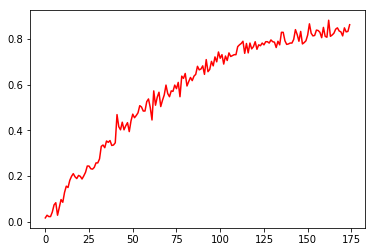

In [5]:
from matplotlib import pyplot as plt
plt.plot(acc_arr,'r-')

In [6]:
raw_test = panda.read_csv("/kaggle/input/devanagari-character-set/data.csv").to_numpy()
y_test = raw_test[:18000,1024]
lookupTable_y, y_test_indexed = np.unique(y_test, return_inverse=True)
print(lookupTable_y)
x_test = raw_test[:18000,:-1].reshape(18000,1,32,32)
x_test = x_test.astype(dtype=float)
print(x_test.shape)
y_test_pred = net(torch.tensor(x_test).float())

['character_01_ka' 'character_02_kha' 'character_03_ga' 'character_04_gha'
 'character_05_kna' 'character_06_cha' 'character_07_chha'
 'character_08_ja' 'character_09_jha']
(18000, 1, 32, 32)


In [7]:
y = torch.tensor(y_test_indexed)
print((torch.argmax(y_test_pred,dim=1) == y).float().mean().item())



0.8376666903495789
